In [41]:
import datetime
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import plotly.express as px
import numpy as np

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

print("import succesfull")

import succesfull


In [42]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [43]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [44]:
df.timestamp = pd.to_datetime(df['timestamp'])

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [46]:
df = df.set_index('timestamp').resample("H").mean()

In [47]:
fig = px.line(df.reset_index(), x = 'timestamp',y = 'value',title = 'NYC_Taxi_Demand')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1y',step='month',stepmode = "backward"),
                        dict(count = 2,label = '3y',step='month',stepmode = "backward"),
                        dict(count = 3,label = '5y',step='month',stepmode = "todate"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [48]:
from fbprophet import Prophet

In [49]:
taxi_df = df.reset_index()[['timestamp','value']].rename({'timestamp':'ds','value':'y'}, axis='columns')

In [50]:
taxi_df

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [51]:
train = taxi_df[(taxi_df['ds']>='2014-07-01') & (taxi_df['ds']<='2015-01-27')]
test = taxi_df[(taxi_df['ds']>'2015-01-27')]

In [52]:
train.shape

(5041, 2)

In [53]:
test.shape

(119, 2)

In [54]:
test

,ds,y
5041,2015-01-27 01:00:00,39.5
5042,2015-01-27 02:00:00,29.0
5043,2015-01-27 03:00:00,9.5
5044,2015-01-27 04:00:00,14.5
5045,2015-01-27 05:00:00,29.0
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [55]:
m = Prophet(changepoint_range=0.95) #change_point rage is equal to cofidence interval 

In [56]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [57]:
m.params

OrderedDict([('k', array([[0.07373494]])),
             ('m', array([[0.39389129]])),
             ('delta',
              array([[-2.55901610e-07, -2.69750945e-02, -3.69485717e-02,
                      -8.94811582e-08, -5.09812660e-07,  4.35497178e-07,
                       1.09553616e-01, -1.43005413e-07, -9.48734967e-09,
                      -1.72610152e-08,  1.51170762e-08, -6.51745510e-07,
                      -9.91920798e-03, -1.01923088e-01, -1.11610454e-01,
                      -6.86120356e-02, -2.48045086e-08, -4.69338966e-08,
                      -9.52812707e-08, -2.25448296e-05, -3.68325315e-06,
                       3.07767697e-02,  1.48909879e-01,  1.71667134e-07,
                      -3.81776170e-07]])),
             ('sigma_obs', array([[0.09960285]])),
             ('beta',
              array([[ 0.04096011,  0.00863402, -0.03045045, -0.00711557,  0.01306731,
                       0.00525571, -0.16876983, -0.04728384, -0.10865651,  0.0299872 ,
                 

In [58]:
future = m.make_future_dataframe(periods=119,freq='H')
future.tail(167)

,ds
4993,2015-01-25 01:00:00
4994,2015-01-25 02:00:00
4995,2015-01-25 03:00:00
4996,2015-01-25 04:00:00
4997,2015-01-25 05:00:00
...,...
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00


In [59]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23799.138475,18865.242502,28703.623711
5156,2015-01-31 20:00:00,24363.213509,19491.075179,28828.454510
5157,2015-01-31 21:00:00,23239.944146,18835.104168,28518.969861
5158,2015-01-31 22:00:00,21048.028181,16352.834708,25729.637846
5159,2015-01-31 23:00:00,18520.934054,13457.262206,23262.636747


In [60]:
results = pd.concat([taxi_df.set_index('ds')['y'],forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]],axis=1)

In [61]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8556.176093,18214.819662
2014-07-01 01:00:00,5433.0,10220.194393,5935.096731,14797.391649
2014-07-01 02:00:00,3346.5,6656.895387,1778.948365,11666.263034
2014-07-01 03:00:00,2216.5,3435.918478,-1018.131020,8197.358446
2014-07-01 04:00:00,2189.5,2005.330278,-2623.410686,6877.571549
...,...,...,...,...
2015-01-31 19:00:00,28288.5,23799.138475,18865.242502,28703.623711
2015-01-31 20:00:00,24138.0,24363.213509,19491.075179,28828.454510
2015-01-31 21:00:00,24194.5,23239.944146,18835.104168,28518.969861


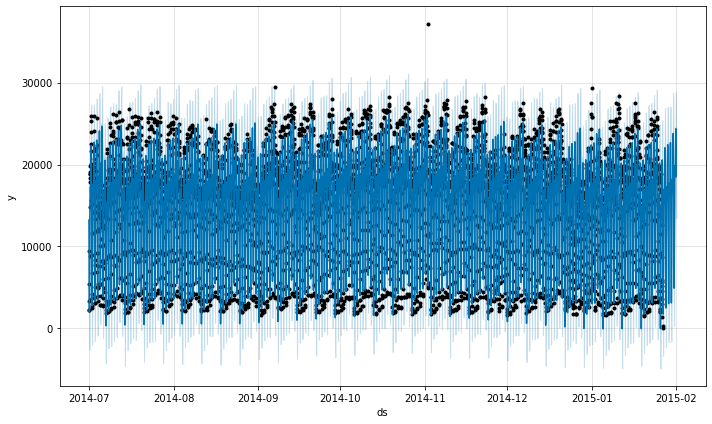

In [62]:
fig1 = m.plot(forecast)

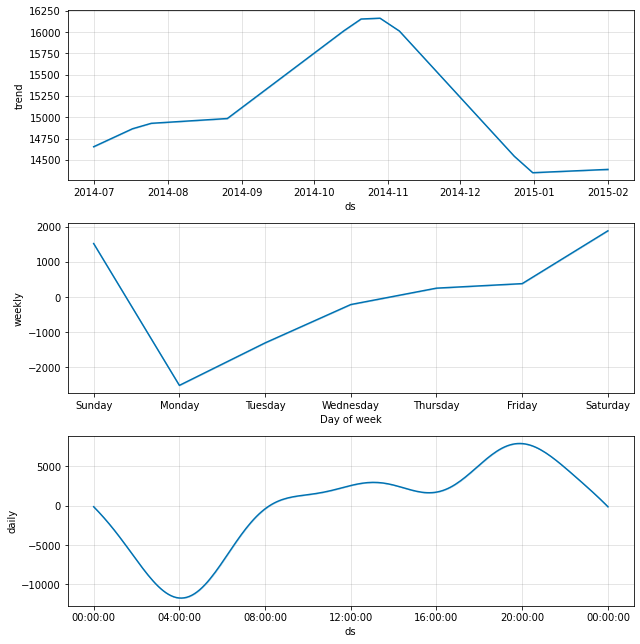

In [63]:
comp = m.plot_components(forecast)

In [64]:
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13228.339092,8556.176093,18214.819662
2014-07-01 01:00:00,5433.0,10220.194393,5935.096731,14797.391649
2014-07-01 02:00:00,3346.5,6656.895387,1778.948365,11666.263034
2014-07-01 03:00:00,2216.5,3435.918478,-1018.131020,8197.358446
2014-07-01 04:00:00,2189.5,2005.330278,-2623.410686,6877.571549
...,...,...,...,...
2015-01-31 19:00:00,28288.5,23799.138475,18865.242502,28703.623711
2015-01-31 20:00:00,24138.0,24363.213509,19491.075179,28828.454510
2015-01-31 21:00:00,24194.5,23239.944146,18835.104168,28518.969861


In [65]:
results['error'] = results['y'] - results['yhat']

In [66]:
results['uncertainity'] = results['yhat_upper'] - results['yhat_lower']

In [67]:
results.shape

(5160, 6)

In [68]:
results[results['error'].abs() > 1.5*results['uncertainity']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-11-02 01:00:00,37204.5,14215.495541,9461.819901,19256.248771,22989.004459,9794.428869
2015-01-01 01:00:00,29292.0,11402.685988,6981.812262,16546.425066,17889.314012,9564.612803
2015-01-01 02:00:00,25753.5,7767.243272,2775.654535,12475.764890,17986.256728,9700.110354
2015-01-01 03:00:00,22067.0,4476.113854,-138.081653,9054.616795,17590.886146,9192.698448
2015-01-26 19:00:00,4565.5,19788.034941,14742.730579,24525.444767,-15222.534941,9782.714187
2015-01-26 20:00:00,3630.5,20563.358247,15736.960262,25439.276775,-16932.858247,9702.316513
2015-01-26 21:00:00,2907.0,19664.535017,15045.684620,24151.832085,-16757.535017,9106.147465
2015-01-26 22:00:00,1324.5,17708.853168,12441.061822,22217.643582,-16384.353168,9776.581760
2015-01-26 23:00:00,243.0,15428.310469,10617.068486,19938.632509,-15185.310469,9321.564023


In [69]:
results['anomaly'] = results.apply(lambda x: 'Yes' if (np.abs(x['error']) > 1.5*x['uncertainity']) else 'No', axis=1)

In [70]:
results.shape

(5160, 7)

In [71]:
results.reset_index()

,ds,y,yhat,yhat_lower,yhat_upper,error,uncertainity,anomaly
0,2014-07-01 00:00:00,9485.5,13228.339092,8556.176093,18214.819662,-3742.839092,9658.643569,No
1,2014-07-01 01:00:00,5433.0,10220.194393,5935.096731,14797.391649,-4787.194393,8862.294918,No
2,2014-07-01 02:00:00,3346.5,6656.895387,1778.948365,11666.263034,-3310.395387,9887.314668,No
3,2014-07-01 03:00:00,2216.5,3435.918478,-1018.131020,8197.358446,-1219.418478,9215.489466,No
4,2014-07-01 04:00:00,2189.5,2005.330278,-2623.410686,6877.571549,184.169722,9500.982236,No
...,...,...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,23799.138475,18865.242502,28703.623711,4489.361525,9838.381209,No
5156,2015-01-31 20:00:00,24138.0,24363.213509,19491.075179,28828.454510,-225.213509,9337.379331,No
5157,2015-01-31 21:00:00,24194.5,23239.944146,18835.104168,28518.969861,954.555854,9683.865693,No
5158,2015-01-31 22:00:00,26515.0,21048.028181,16352.834708,25729.637846,5466.971819,9376.803137,No


In [72]:
fig = px.scatter(results.reset_index(), x = 'ds',y='y',color= 'anomaly',title = 'NYC_Taxi_Demand')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1y',step='month',stepmode = "backward"),
                        dict(count = 2,label = '3y',step='month',stepmode = "backward"),
                        dict(count = 3,label = '5y',step='month',stepmode = "todate"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

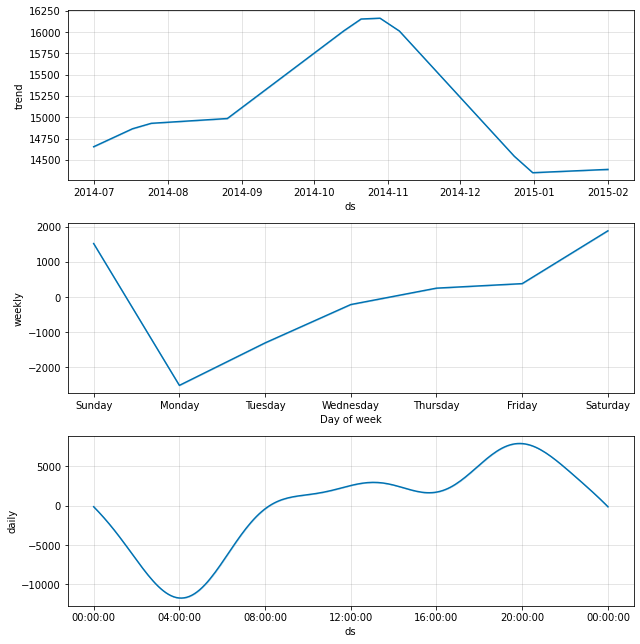

In [73]:
comp= m.plot_components(forecast)